# Confirming MSD statistics for (+) chemotaxis and (-) chemotaxis

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import freud as fr

In [4]:
import numpy as np

def _autocorr_fft_1d(x):
    """
    Return autocorrelation sum_{t} x[t] * x[t+tau] for tau=0..M-1.
    No mean removal (not needed for MSD formula below).
    Uses zero-padding to avoid circular wrap.
    """
    x = np.asarray(x, dtype=np.float64)
    M = x.shape[0]
    nfft = 1 << (2*M - 1).bit_length()  # pow2 >= 2M
    xp = np.zeros(nfft, dtype=np.float64)
    xp[:M] = x
    F = np.fft.rfft(xp)
    S = F * np.conj(F)
    acf = np.fft.irfft(S, nfft)[:M].real
    return acf

def msd_fft_single(r):
    """
    MSD for a single trajectory r with shape (M, d).
    Returns MSD[0..M-1] with time-origin averaging (unbiased by counts).
    """
    r = np.asarray(r, dtype=np.float64)
    if r.ndim == 1:
        r = r[:, None]
    M, d = r.shape

    # sum over dimensions of the autocorrelation r(t)·r(t+τ)
    acf_dot = np.zeros(M, dtype=np.float64)
    for k in range(d):
        acf_dot += _autocorr_fft_1d(r[:, k])

    # prefix sums of |r|^2 to get windowed sums quickly
    rsq = np.sum(r*r, axis=1)                 # (M,)
    csum = np.concatenate(([0.0], np.cumsum(rsq)))  # len M+1

    taus = np.arange(M)                       # 0..M-1
    counts = (M - taus).astype(np.float64)    # number of pairs per τ

    # sum_{t=0}^{M-τ-1} |r(t)|^2 = csum[M-τ] - csum[0]
    sum_rsq_t      = csum[M - taus] - csum[0]
    # sum_{t=0}^{M-τ-1} |r(t+τ)|^2 = csum[M] - csum[taus]
    sum_rsq_t_tau  = csum[M] - csum[taus]

    # MSD(τ) = (sum |r(t+τ)|^2 + sum |r(t)|^2 - 2 * sum r(t)·r(t+τ)) / counts
    msd = (sum_rsq_t + sum_rsq_t_tau - 2.0 * acf_dot) / counts
    return msd

def compute_msd_fft(positions, max_lag=None, stride=1, average=True):
    """
    positions: array with shape (N, M, d)  [N particles, M frames, d dims]
               (if you have (M, N, d), pass positions.swapaxes(0,1))
    max_lag:   compute up to this lag (inclusive); None -> M-1
    stride:    subsample frames to reduce M (e.g., 10 keeps every 10th frame)
    average:   if True, return particle-mean MSD; else return (N, L) per-particle.
    """
    pos = np.asarray(positions, dtype=np.float64)
    assert pos.ndim == 3, "positions must be (N, M, d)"
    N, M, d = pos.shape

    # optional temporal downsampling
    pos = pos[:, ::stride, :]
    M = pos.shape[1]

    L = M if max_lag is None else int(min(max_lag, M-1)) + 1
    out = np.empty((N, L), dtype=np.float64)
    for n in range(N):
        msd_full = msd_fft_single(pos[n])
        out[n] = msd_full[:L]
    return out.mean(axis=0) if average else out


In [11]:
POS_PATH = "/home/alabbasm/msbt/magnetotactic_modeling/model_testing/rounds/01_nochemo_3x3x3_mm_n1000_t1000/postitions_nochemo_3x3x3_mm_n1000_t1000.npy"

In [12]:
dt = 0.002   # <-- use your sim's timestep
pos_nochemo = np.load(POS_PATH)              # (T, N, 3)
msd_nochemo = compute_msd_fft(pos_nochemo.swapaxes(0,1), stride=10, average=True)

# Build time array
L = msd_nochemo.shape[0]
times = np.arange(L) * dt * 10   # factor 10 since stride=10 above

In [1]:
WCHEMOPATH = "/home/alabbasm/msbt/magnetotactic_modeling/pMagMove/src/postitions_wchemo_3x3x3_mm_n1000_t1000.npy"

In [6]:
dt = 0.002   # <-- use your sim's timestep
pos_wchemo = np.load(WCHEMOPATH)              # (T, N, 3)
msd_wchemo = compute_msd_fft(pos_wchemo.swapaxes(0,1), stride=10, average=True)

# Build time array
L = msd_wchemo.shape[0]
times = np.arange(L) * dt * 10   # factor 10 since stride=10 above

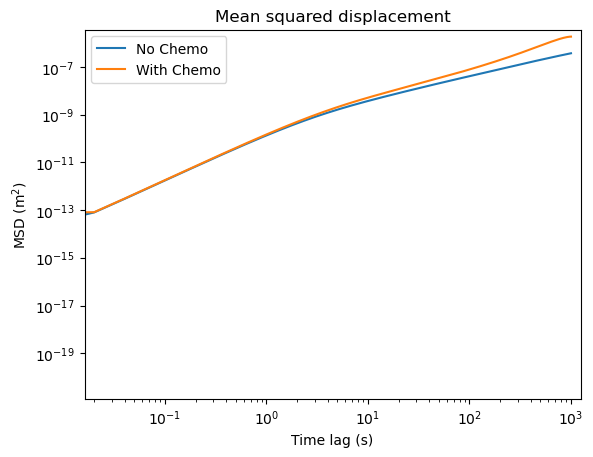

In [20]:
plt.loglog(times, msd_nochemo, label='No Chemo')
plt.loglog(times, msd_wchemo, label='With Chemo')
plt.legend()
plt.xlabel("Time lag (s)")
plt.ylabel("MSD (m$^2$)")
plt.title("Mean squared displacement")

# Let matplotlib pick tight limits based on the plotted data
plt.autoscale(enable=True, axis='both', tight=True)

# Optional small margins so lines don’t touch the frame
plt.margins(x=0.02, y=0.02)

plt.show()


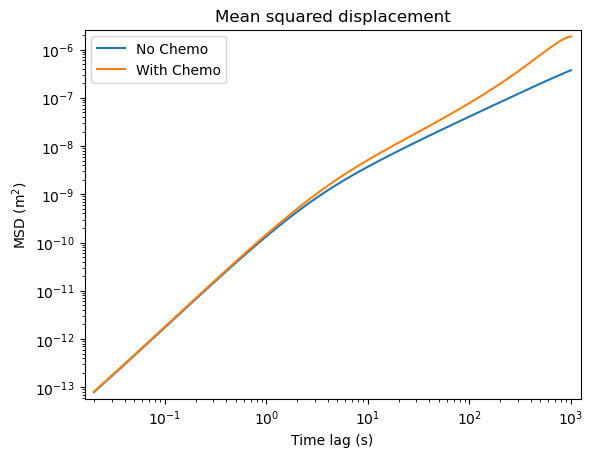

In [21]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# drop lag-0 and any nonpositive/NaN values for each series
def mask_xy(x, y):
    m = (x > 0) & (y > 0) & np.isfinite(x) & np.isfinite(y)
    return x[m], y[m]

x0, y0 = mask_xy(times, msd_nochemo)
x1, y1 = mask_xy(times, msd_wchemo)

ax.plot(x0, y0, label='No Chemo')
ax.plot(x1, y1, label='With Chemo')

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel("Time lag (s)")
ax.set_ylabel("MSD (m$^2$)")
ax.set_title("Mean squared displacement")
ax.legend()

# recompute limits from the plotted data and make them tight
ax.relim()
ax.autoscale(tight=True)
ax.margins(x=0.02, y=0.02)  # tiny breathing room

plt.show()


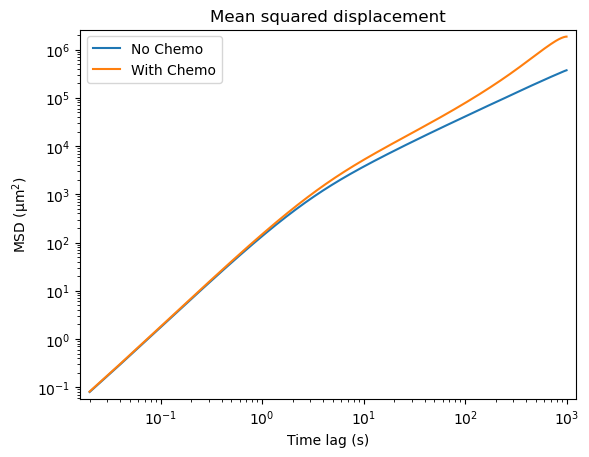

In [22]:
# Convert y-axis from m^2 to µm^2
msd_nochemo_um2 = msd_nochemo * 1e12
msd_wchemo_um2 = msd_wchemo * 1e12

plt.loglog(times[1:], msd_nochemo_um2[1:], label='No Chemo')
plt.loglog(times[1:], msd_wchemo_um2[1:], label='With Chemo')
plt.legend()
plt.xlabel("Time lag (s)")
plt.ylabel("MSD (µm$^2$)")  # update units
plt.title("Mean squared displacement")
plt.autoscale(tight=True); plt.margins(0.02, 0.02)
plt.show()